## Basket option pricing with neural network and Monte Carlo solver

This analysis is organized as follows:
1. Simulate approximate prices of 10,000 European basket options using MP-RG's formula.
1. Train a fully-connected artifical neural network to estimate option prices.
1. For a subset of the testing data, compare option prices from the neural network model with those from a Monte Carlo solver.


In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import time as t
import pandas as pd 

from src.simulation import SimulateBasketPrices
from src.nn_train import PricingNetwork
from src.options import BasketOption

In [2]:
sns.set_style('whitegrid')

In [3]:
tf.random.set_seed(321)
np.random.seed(123)

#### 1. Simulate approximate prices with Levy's formula

In [4]:
# Average price of the simulated assets. The 
# simulator will add normal noise to all simulated assets. 
prices = np.ones(4)*100.
# Average volatility of simulated assets. The simulator
# will add a small uniform random on [-0.025,0.025).
vol = 0.4
# For each simulated basket, the underlying assets have the 
# same correlation structure.
corr = np.array([[1.,0.5,0.5,0.5],
                 [0.5,1.,0.5,0.5],
                 [0.5,0.5,1.,0.5],
                 [0.5,0.5,0.5,1.]])

In [5]:
# Simulate 10,000 baskets, each with 4 underlying assets 
simulator = SimulateBasketPrices(4, n_prices=10000)
# The simulation routine uses the BasketOption class defined in options.py
simulated_prices = simulator.simulate_prices(prices, vol, corr)

#### 2. Train a neural network model to estimate option prices

In [6]:
train_prices = simulated_prices.sample(frac=0.8, random_state=123)
test_prices = simulated_prices.drop(train_prices.index)

X_train, X_test = train_prices.copy(), test_prices.copy()
y_train, y_test = X_train.pop('Basket_Price'), X_test.pop('Basket_Price')

X_train = X_train.to_numpy() if isinstance(X_train, pd.DataFrame) else X_train
X_test = X_test.to_numpy() if isinstance(X_test, pd.DataFrame) else X_test

In [7]:
# The PricingNetwork class has the model build, compilation, and
# testing functionality.
pricer = PricingNetwork((X_train, y_train), (X_test, y_test))

C:\Users\Vlada\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


The model has 4+2(N_assets) input features:
* N features for the price of each asset
* N features for the weight of each asset in the basket
* Strike price
* Maturity date
* Volatility (all assets have equal volatility for the Levy formula)
* Risk-free interest rate (set to zero for simplicity)

The model architecture is inspired by Ke & Yang 2019 (capstone project for Stanford CS230). They found a 4-layer network with ReLU activations and batch normalization to work well. Therefore, the network I implement here has three layers with 256 nodes each and a final layer with a single node. The first three layers are followed by batch norm. I also chose to normalize the features before passing into the neural network.

Throughout training, the validation loss was lower than the training loss. This could be a quirk of the random train/test split and isn't terribly concerning for this simulated dataset, which has the same distributions for train and test. In a real world dataset of historical prices, I would look try a cross-validation to avoid this sort of variance in performance estimation.  

In [8]:
pricer.create_ann()
# Fit the model using the Adam optimizer and MSE loss function
history = pricer.fit_model(epochs=100)

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 420.5332 - val_loss: 105.1892
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 79.6577 - val_loss: 77.9994
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 43.5946 - val_loss: 33.8038
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29.2645 - val_loss: 21.1478
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 22.2392 - val_loss: 9.9514
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.1973 - val_loss: 6.2741
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14.5743 - val_loss: 4.2446
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3589 - val_loss: 4.5441
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10.9256 - val_loss: 4.9651
Epoch 10/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10.5436 - val_loss: 5.1259
Epoch 11/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.3740 - val_loss: 4.4507
Epoch 12/100
250/250 ━━━━

In [9]:
test_prices['ANN_Price'] = pricer.pricing_model.predict(X_test)
test_prices['Model_Error'] = abs(test_prices.ANN_Price - test_prices.Basket_Price)
test_prices['Log_Error'] = np.log10(test_prices['Model_Error'])
# Get ratio of weighted asset price to strike price
test_prices['wS/K'] = (test_prices.iloc[:,[0,1,2,3]].to_numpy()\
                       *test_prices.iloc[:,[4,5,6,7]].to_numpy()).sum(axis=1) / test_prices['Strike']

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


From the description below, the test set **mean absolute error (MAE) of the network is 0.554** with range [4.41e-4, 33.88].

In [10]:
test_prices.describe()

,Price_1,Price_2,Price_3,Price_4,Weight_1,Weight_2,Weight_3,Weight_4,Strike,Maturity,Volatility,Rate,Basket_Price,ANN_Price,Model_Error,Log_Error,wS/K
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.0,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,99.937571,100.030452,100.128235,100.214959,0.251805,0.247513,0.252507,0.248174,100.042777,8.108500,0.399955,0.0,29.997253,30.398275,0.972493,-0.299624,1.098351
std,10.208839,9.913643,9.981491,10.116169,0.134666,0.137108,0.137075,0.136743,28.886819,4.316717,0.014468,0.0,12.220725,12.550650,1.956306,0.563518,0.360206
min,63.251973,69.502320,68.261599,64.805747,0.000896,0.000219,0.000229,0.000928,50.003862,1.000000,0.375030,0.0,1.151346,0.000000,0.000197,-3.705125,0.579738
25%,92.921248,93.298141,93.375828,93.238979,0.150122,0.142407,0.152136,0.145992,75.326070,4.000000,0.387688,0.0,21.423008,21.958959,0.271287,-0.566571,0.797876
50%,100.186662,100.155392,100.074790,100.029244,0.253997,0.249541,0.253336,0.247768,98.802742,8.000000,0.399977,0.0,28.975257,29.025698,0.621609,-0.206483,1.001821
75%,107.025016,106.529756,106.894122,106.578535,0.343896,0.341301,0.343690,0.339035,125.754931,12.000000,0.412597,0.0,38.456032,38.737641,1.159885,0.064415,1.332280
max,131.804283,138.822470,133.444092,140.680969,0.848419,0.896097,0.860552,0.808793,149.997277,15.000000,0.424976,0.0,64.900664,94.719231,51.782827,1.714186,2.186009


Visual inspection of the pairplot below suggests no strong relationships between model error and the input features.

In [11]:
#sns.pairplot(test_prices[['Strike','Maturity','Volatility','Basket_Price','wS/K','Log_Error']])
#plt.savefig('figures/network_performance_pairplot.pdf')

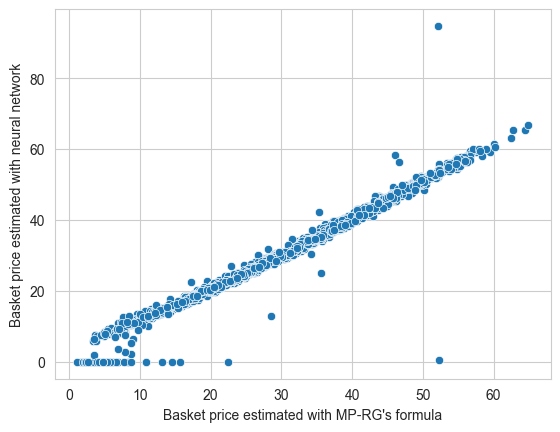

In [12]:
sns.scatterplot(x='Basket_Price', y='ANN_Price', data=test_prices)
_=plt.xlabel("Basket price estimated with MP-RG's formula")
_=plt.ylabel("Basket price estimated with neural network")
plt.savefig('figures/nn-levy_test-data.png')

Note that both outliers (top rows below) had the maximum possible time to maturity (15) and a fairly high price-to-strike ratio. 

In [13]:
test_prices.sort_values('Model_Error', ascending=False)

,Price_1,Price_2,Price_3,Price_4,Weight_1,Weight_2,Weight_3,Weight_4,Strike,Maturity,Volatility,Rate,Basket_Price,ANN_Price,Model_Error,Log_Error,wS/K
4425,89.911290,132.171282,96.050894,86.581841,0.295549,0.202690,0.374693,0.127068,53.242362,11,0.379030,0.0,52.218003,0.435176,51.782827,1.714186,1.884859
635,114.409629,119.328206,119.412493,100.555255,0.060732,0.222900,0.143909,0.572459,67.784024,15,0.391898,0.0,52.184367,94.719231,42.534864,1.628745,1.597646
4048,95.311481,118.080214,106.216794,116.572902,0.739755,0.002759,0.202466,0.055020,149.997277,13,0.381954,0.0,22.426055,0.000000,22.426055,1.350753,0.658359
7038,86.836159,94.643093,100.033372,134.591114,0.414931,0.169974,0.013637,0.401458,147.543006,4,0.410334,0.0,15.614023,0.000000,15.614023,1.193515,0.728701
4343,90.815877,127.955787,104.854653,109.833706,0.176136,0.212850,0.534252,0.076763,114.907213,8,0.379397,0.0,28.582120,12.980891,15.601229,1.193159,0.937114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5055,88.924400,88.901139,98.701321,106.737437,0.220224,0.363431,0.120668,0.295677,135.679423,10,0.422640,0.0,21.291520,21.290333,0.001187,-2.925552,0.702852
1862,113.177794,108.350217,87.517697,125.811877,0.407986,0.173836,0.361258,0.056920,130.385780,9,0.402365,0.0,24.800489,24.801556,0.001067,-2.971810,0.796006
3543,102.919984,80.525042,77.455838,105.385321,0.326733,0.110269,0.246504,0.316494,100.787541,13,0.410121,0.0,29.958445,29.957550,0.000895,-3.048376,0.942118
5821,99.191303,93.482519,98.635262,99.111799,0.273223,0.287579,0.322420,0.116778,78.900688,9,0.413215,0.0,36.163316,36.162788,0.000528,-3.277644,1.233969


#### 3. Compare a subset of the test cases to a Monte Carlo solver

In [14]:
subset = test_prices.iloc[:100]

In [15]:
mc_prices = []
for i in range(subset.shape[0]):
    opt = BasketOption(
        subset.iloc[i,4:8].to_numpy(),
        subset.iloc[i,:4].to_numpy(),
        subset.iloc[i].Volatility,
        corr,
        subset.iloc[i].Strike,
        subset.iloc[i].Maturity,
        subset.iloc[i].Rate
    )

    mc_prices.append(opt.get_mc_price(n_paths=2000000))

subset['MC_Price'] = mc_prices

C:\Users\Vlada\AppData\Local\Temp\ipykernel_15572\178142683.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['MC_Price'] = mc_prices


In [16]:
subset['ANN-MC_Error'] = abs(subset['ANN_Price'] - subset['MC_Price'])

C:\Users\Vlada\AppData\Local\Temp\ipykernel_15572\2212790973.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['ANN-MC_Error'] = abs(subset['ANN_Price'] - subset['MC_Price'])


From the description below, **mean absolute error (MAE) of the network is 0.85** with range [2.15e-2, 2.06] (relative to Monte Carlo).

In [17]:
subset.describe()

,Price_1,Price_2,Price_3,Price_4,Weight_1,Weight_2,Weight_3,Weight_4,Strike,Maturity,Volatility,Rate,Basket_Price,ANN_Price,Model_Error,Log_Error,wS/K,MC_Price,ANN-MC_Error
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,99.038408,99.378233,100.060430,99.930234,0.224519,0.255158,0.241083,0.279241,95.585104,8.780000,0.401733,0.0,31.721188,32.248898,0.873775,-0.283801,1.131680,39.154110,7.202682
std,10.590967,9.567476,9.435509,9.747892,0.123810,0.122364,0.127059,0.125431,26.847684,4.375275,0.014479,0.0,11.338850,11.567006,1.018581,0.498811,0.339782,13.666714,4.577322
min,71.663425,77.182476,75.751637,78.405584,0.002799,0.008791,0.012470,0.043153,52.556779,1.000000,0.375659,0.0,5.555650,0.000000,0.009947,-2.002298,0.632013,5.487949,0.383926
25%,92.093974,92.603908,94.656050,94.497170,0.139158,0.185623,0.155137,0.214058,71.898710,5.000000,0.391255,0.0,23.177082,23.779657,0.312989,-0.504496,0.843040,28.126918,3.216851
50%,99.845334,100.583688,99.791063,99.664907,0.231841,0.255067,0.244201,0.278182,94.309480,9.000000,0.402708,0.0,32.282248,32.520864,0.625416,-0.203832,1.046450,39.360946,6.984497
75%,106.248417,104.563239,107.014474,104.460689,0.301047,0.332805,0.323302,0.354487,114.360091,12.000000,0.414521,0.0,39.613491,40.447841,1.038584,0.016432,1.409298,49.656421,11.404802
max,122.142420,120.272487,119.594113,135.715792,0.575822,0.623859,0.582195,0.808793,147.295476,15.000000,0.424878,0.0,52.888313,54.967556,8.259316,0.916944,1.930046,60.790796,16.801729


Visual inspection of the pairplot suggests a relationship between strike price and absolute error of neural network relative to Monte Carlo (MC) estimates.

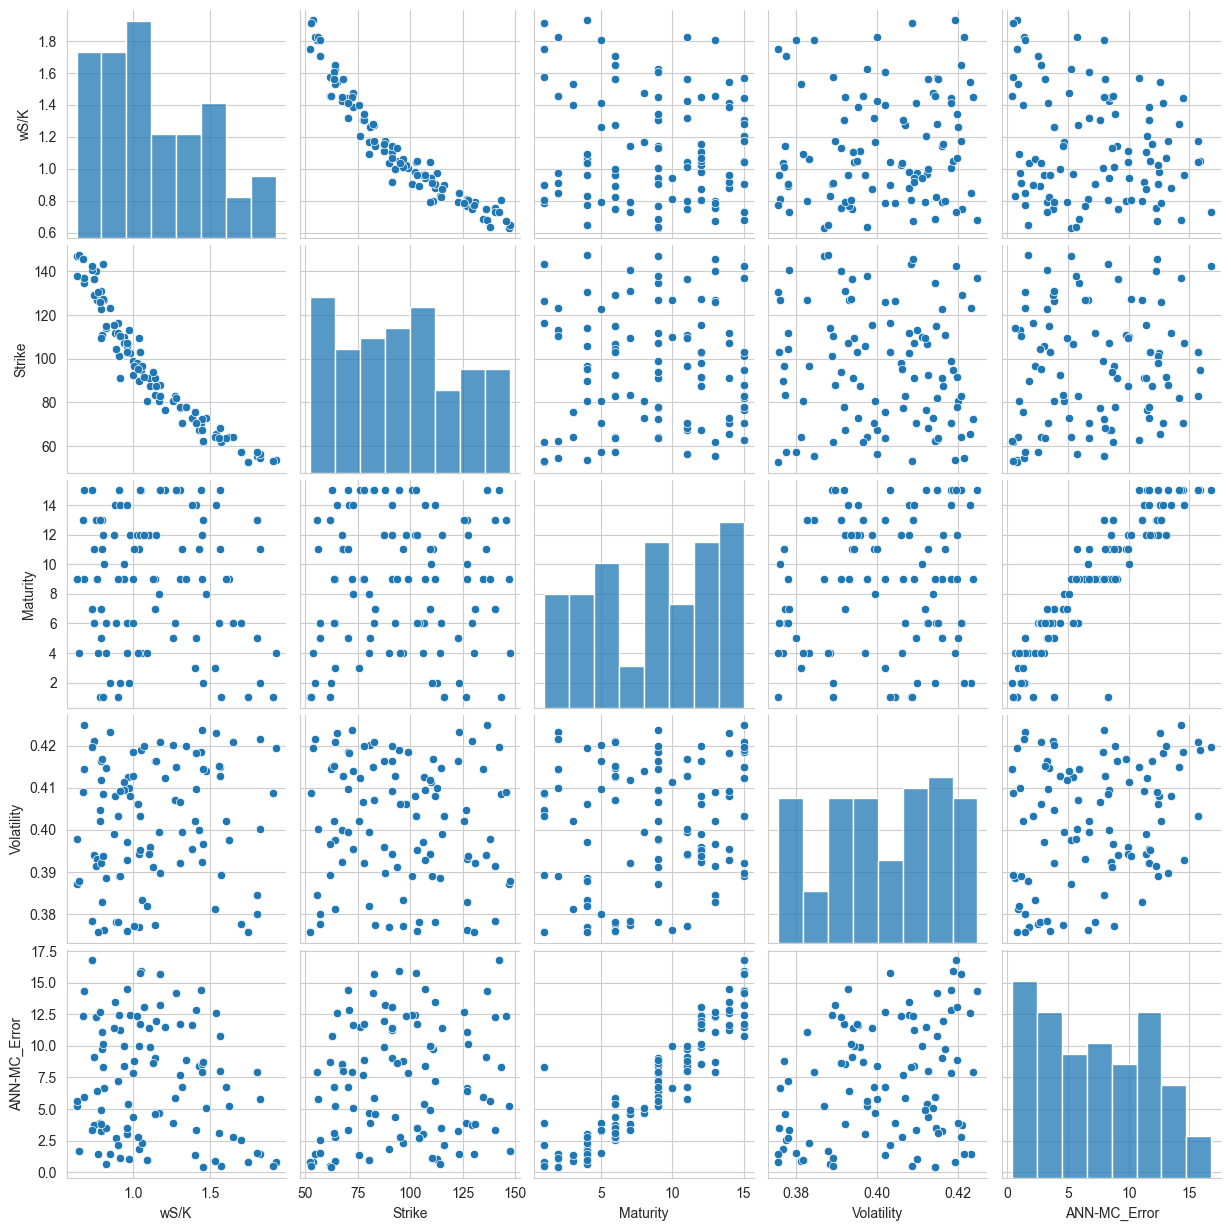

In [18]:
sns.pairplot(subset[['wS/K','Strike','Maturity','Volatility','ANN-MC_Error']])

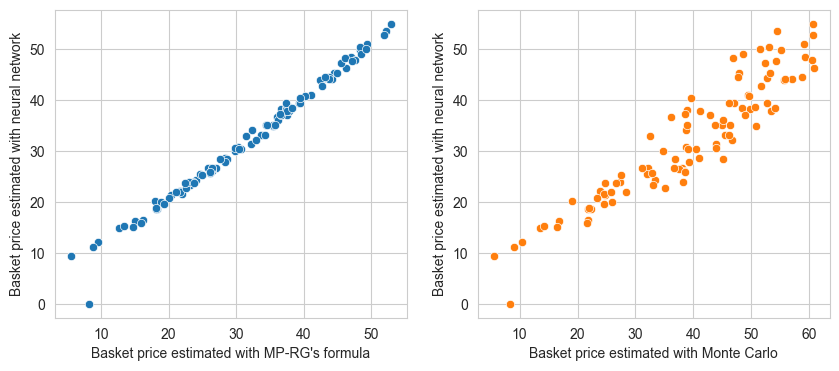

In [19]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.scatterplot(x='Basket_Price', y='ANN_Price', data=subset, ax=ax[0])
sns.scatterplot(x='MC_Price', y='ANN_Price', data=subset, ax=ax[1], color='C1')

_=ax[0].set_xlabel("Basket price estimated with MP-RG's formula")
_=ax[0].set_ylabel("Basket price estimated with neural network")
_=ax[1].set_xlabel("Basket price estimated with Monte Carlo")
_=ax[1].set_ylabel("Basket price estimated with neural network")
plt.savefig('figures/nn-mc_prices.png')